In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers, Sequential

In [4]:
train_path  = r"D:\Research Internship\LaneDetection\tusimple_preprocessed\training"

In [5]:
img_generator = keras.preprocessing.image.ImageDataGenerator()
seed = 10
images_set = img_generator.flow_from_directory(
    train_path,
    shuffle=False,
    batch_size=64,
    class_mode='binary',
    target_size=(256, 320)
)

Found 7252 images belonging to 2 classes.


In [6]:
'''
Assign the images in 'images_set' to two seperate arrays:
assign the road images to 'X' and the ground truth masks to 'Y'
'''
num_images = 7252 # gotten from the output of the cell above
num_batches = num_images // 64 + 1

# initialize an empty list to store the images
X = []
Y = []
# loop over the batches and extract the images
for i in range(num_batches):
    batch = next(images_set)
    batch_images = batch[0] # this contains the images
    batch_labels = batch[1] # this contains 0s and 1s
    for ind, lb in enumerate(batch_labels):
        '''
        a label of 0 means the image belongs to ground truth image,
        and a label of 1 means that the image belongs to the ground truth mask
        '''
        if lb == 0:
            X.append(batch_images[ind])
        else:
            Y.append(np.mean(batch_images[ind], axis=2)) # Y shape is (m, 256, 320)
    if i % 10 == 0:
        print(f'Batch {i}')

# convert the lists to numpy arrays
X = np.array(X)
Y = np.array(Y)

Batch 0
Batch 10
Batch 20
Batch 30
Batch 40
Batch 50
Batch 60
Batch 70
Batch 80
Batch 90
Batch 100
Batch 110


In [7]:
# shuffle the dataset
from sklearn.utils import shuffle
X, Y = shuffle(X, Y, random_state=100)

In [8]:
X = np.array(X[:2000])
Y = np.array(Y[:2000])

In [9]:
Y

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       ...,

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0.

0.0

In [ ]:
Y = (Y >= 100).astype('int').reshape(-1, 256, 320, 1)

In [29]:
from sklearn.model_selection import train_test_split
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=.1, random_state=100)


In [30]:
print("Shape of X_train:", X_train.shape)
print("Shape of X_val:", X_val.shape)
print("Shape of Y_train:", Y_train.shape)
print("Shape of Y_val:", Y_val.shape)

Shape of X_train: (1800, 256, 320, 3)
Shape of X_val: (200, 256, 320, 3)
Shape of Y_train: (1800, 256, 320, 1)
Shape of Y_val: (200, 256, 320, 1)


In [31]:
# free the RAM from undesired clutters
import gc
del X, Y, images_set
gc.collect()

1953

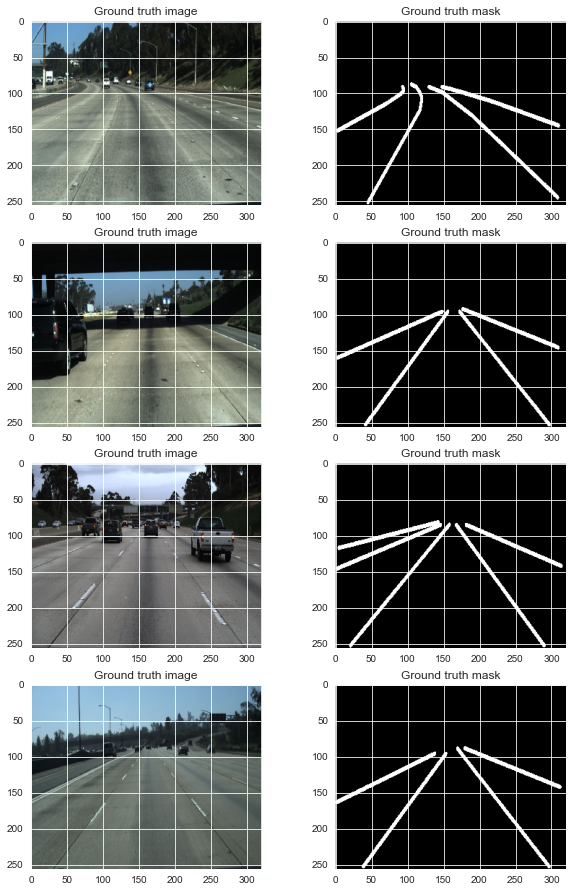

In [32]:
# visualize some samples from the training set
plt.figure(figsize=(10, 40))
s, e = 80, 84
index = 1

for i, j in zip(X_train[s:e], Y_train[s:e]):
    plt.subplot(10, 2, index)
    plt.imshow(i/255.)
    plt.title('Ground truth image')

    plt.subplot(10, 2, index+1)
    plt.imshow(j, cmap='gray')
    plt.title('Ground truth mask')
    index += 2

In [33]:
# model structure
from tensorflow.keras.layers import Input, Conv2DTranspose, Conv2D, MaxPooling2D
from tensorflow.keras.applications.resnet50 import ResNet50

# Define the input shape of the images
input_shape = (256, 320, 3)

# Define the encoder using a pretrained ResNet50 model
encoder = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)

'''
Find the index of the layer named conv3_block4_out of which output size is (32x32xnC)
 because we want to shrink the input's size down upto (32x32xnC) in the encoder section
'''

for i, layer in enumerate(encoder.layers):
    if layer.name == 'conv3_block4_out':
        break

# Create a new model that includes only the layers up to conv3_block4_out
encoder = tf.keras.Model(inputs=encoder.inputs, outputs=encoder.layers[i].output)

# Freeze the weights of the encoder layers to prevent them from being updated during training
for layer in encoder.layers[:50]:
    layer.trainable = False

# Define the decoder using a smaller FCN architecture
def decoder(inputs):
    conv1 = Conv2D(256, (3, 3), activation='relu', padding='same')(inputs)
    up1 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv1)

    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(up1)
    up2 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv2)

    conv3 = Conv2D(64, (3, 3), activation='relu', padding='same')(up2)
    up3 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv3)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(up3)
    return outputs

# Define the input tensor
inputs = Input(input_shape)

# Pass the input through the encoder and decoder to obtain the output
outputs = decoder(encoder(inputs))

# Define the model
model = tf.keras.Model(inputs=inputs, outputs=outputs)

In [34]:
# Compile the model
model.compile(optimizer='adam', loss=keras.losses.BinaryFocalCrossentropy(), metrics=['accuracy'])
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 256, 320, 3)]     0         
                                                                 
 model_2 (Functional)        (None, 32, 40, 512)       1460096   
                                                                 
 conv2d_4 (Conv2D)           (None, 32, 40, 256)       1179904   
                                                                 
 conv2d_transpose_3 (Conv2DT  (None, 64, 80, 256)      262400    
 ranspose)                                                       
                                                                 
 conv2d_5 (Conv2D)           (None, 64, 80, 128)       295040    
                                                                 
 conv2d_transpose_4 (Conv2DT  (None, 128, 160, 128)    65664     
 ranspose)                                                 

In [35]:
# train the model
epochs = 20 
batch_size = 8

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
]

history = model.fit(
    X_train,
    Y_train,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=(X_val, Y_val),
    batch_size=batch_size
)

Epoch 1/20
225/225 [==============================] - 553s 2s/step - loss: 0.0204 - accuracy: 0.9675 - val_loss: 0.0167 - val_accuracy: 0.9750
Epoch 2/20
225/225 [==============================] - 566s 3s/step - loss: 0.0140 - accuracy: 0.9778 - val_loss: 0.0140 - val_accuracy: 0.9774
Epoch 3/20
225/225 [==============================] - 545s 2s/step - loss: 0.0128 - accuracy: 0.9792 - val_loss: 0.0150 - val_accuracy: 0.9779
Epoch 4/20
225/225 [==============================] - 549s 2s/step - loss: 0.0118 - accuracy: 0.9804 - val_loss: 0.0137 - val_accuracy: 0.9784
Epoch 5/20
225/225 [==============================] - 548s 2s/step - loss: 0.0110 - accuracy: 0.9817 - val_loss: 0.0140 - val_accuracy: 0.9773
Epoch 6/20
225/225 [==============================] - 547s 2s/step - loss: 0.0103 - accuracy: 0.9829 - val_loss: 0.0148 - val_accuracy: 0.9778
Epoch 7/20
225/225 [==============================] - 545s 2s/step - loss: 0.0097 - accuracy: 0.9839 - val_loss: 0.0147 - val_accuracy: 0.9786

In [36]:


preds = model.predict(X_val)
preds.max(), preds.min()

7/7 [==============================] - 21s 3s/step


(0.99985355, 8.001178e-17)

In [37]:
model.save()

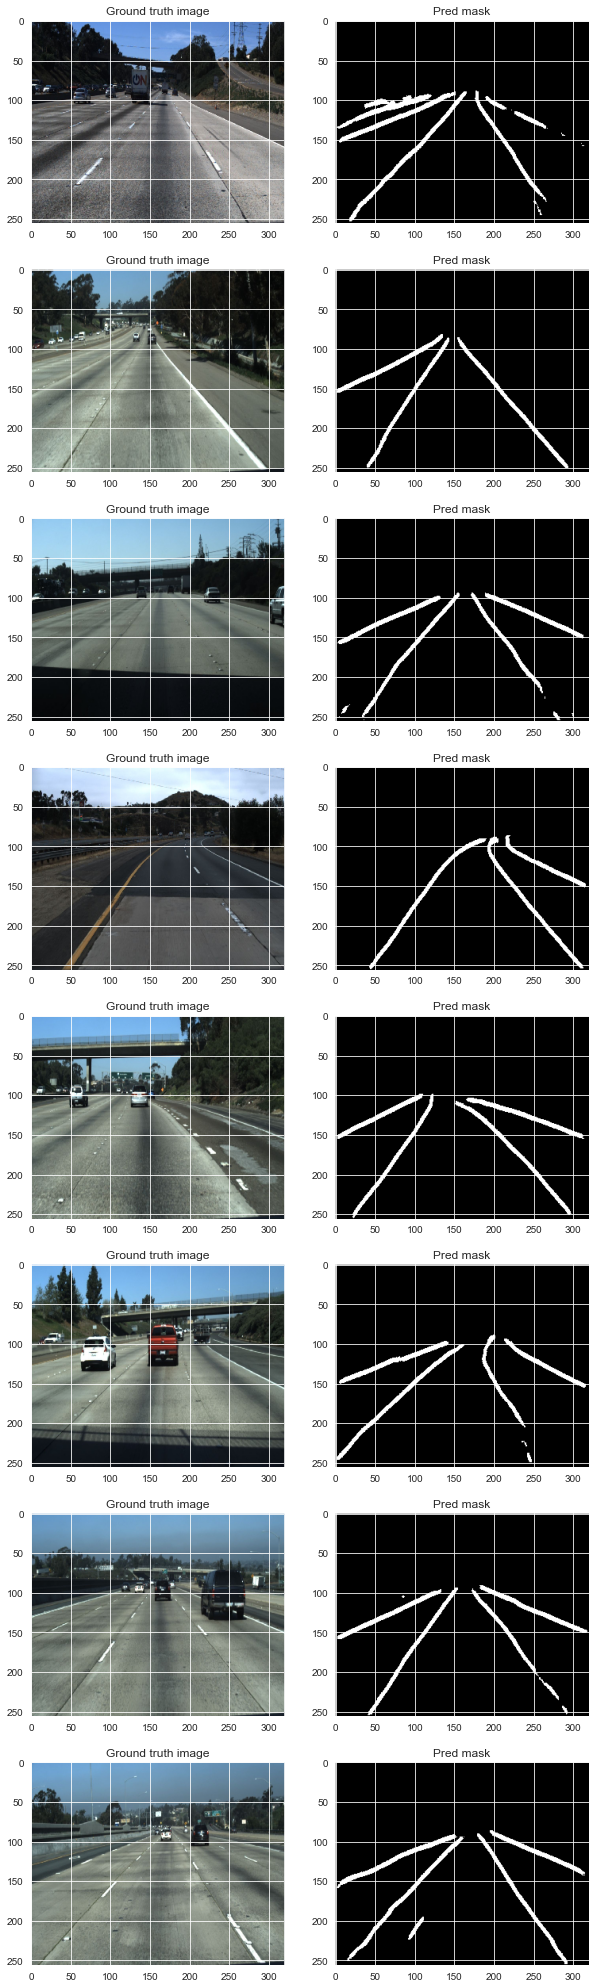

In [38]:
# visualize some results from the val set.
plt.figure(figsize=(10, 45))
s, e = 90, 98
index = 1

preds = (preds >= .5).astype('int')
for i, j, k in zip(X_val[s:e], preds[s:e], Y_val[s:e]):
    # write these images into file as well
    cv2.imwrite(f'./out/img-{index}.jpg', i)
    cv2.imwrite(f'./out/pred-{index}.jpg', j*255.)
    cv2.imwrite(f'./out/ground-{index}.jpg', k*255.)

    plt.subplot(10, 2, index)
    plt.imshow(i/255.)
    plt.title('Ground truth image')

    plt.subplot(10, 2, index+1)
    plt.imshow(j, cmap='gray')
    plt.title('Pred mask')
    index += 2

In [54]:
model.save("D:\College\Research Internship\LaneDetection\TensorflowModel.h5")

In [40]:
# create metrices
accuracy = tf.keras.metrics.Accuracy()
precision = tf.keras.metrics.Precision()
recal = tf.keras.metrics.Recall()
iou = tf.keras.metrics.IoU(num_classes=2, target_class_ids=[1])


# accuracy
accuracy.update_state(Y_val, preds)
accuracy_value = accuracy.result().numpy()
# precision
precision.update_state(Y_val, preds)
precision_value = precision.result().numpy()
# recal
recal.update_state(Y_val, preds)
recal_value = recal.result().numpy()
# f1 score
f1_score = 2 / ((1 / precision_value) + (1 / recal_value))

# Intersection over union (IoU)
iou.update_state(Y_val, preds)
iou_value = iou.result().numpy()

print("Accuracy:", accuracy_value)
print("Precision:", precision_value)
print("Recal:", recal_value)
print('F1 Score: ', f1_score)
print('IoU: ', iou_value)

Accuracy: 0.97756904
Precision: 0.74545085
Recal: 0.7360979
F1 Score:  0.7407448407022071
IoU:  0.58824044


In [41]:
test_path = r"D:\College\Research Internship\LaneDetection\tusimple_preprocessed\test"

In [42]:
img_generator = keras.preprocessing.image.ImageDataGenerator()
seed = 10
images_set = img_generator.flow_from_directory(
    test_path,
    shuffle=False,
    batch_size=64,
    class_mode='binary',
    target_size=(256, 320)
)

Found 5564 images belonging to 2 classes.


In [43]:
'''
Assign the images in 'images_set' to two seperate arrays:
assign the road images to 'X' and the ground truth masks to 'Y'
'''
num_images = 7252 # gotten from the output of the cell above
num_batches = num_images // 64 + 1

# initialize an empty list to store the images
X = []
Y = []
# loop over the batches and extract the images
for i in range(num_batches):
    batch = next(images_set)
    batch_images = batch[0] # this contains the images
    batch_labels = batch[1] # this contains 0s and 1s
    for ind, lb in enumerate(batch_labels):
        '''
        a label of 0 means the image belongs to ground truth image,
        and a label of 1 means that the image belongs to the ground truth mask
        '''
        if lb == 0:
            X.append(batch_images[ind])
        else:
            Y.append(np.mean(batch_images[ind], axis=2)) # Y shape is (m, 256, 320)
    if i % 10 == 0:
        print(f'Batch {i}')

# convert the lists to numpy arrays
X = np.array(X)
Y = np.array(Y)

Batch 0
Batch 10
Batch 20
Batch 30
Batch 40
Batch 50
Batch 60
Batch 70
Batch 80
Batch 90
Batch 100
Batch 110


In [44]:
Y = (Y >= 100).astype('int').reshape(-1, 256, 320, 1)

In [45]:
test_pred = model.predict(X)

141/141 [==============================] - 695s 5s/step


In [46]:
test_pred

array([[[[2.30868551e-04],
         [1.55435540e-04],
         [3.45235923e-04],
         ...,
         [6.44978276e-03],
         [1.43019184e-02],
         [1.51108373e-02]],

        [[3.40242659e-05],
         [2.82962374e-05],
         [1.04075361e-05],
         ...,
         [1.30981591e-03],
         [3.34938243e-03],
         [5.68546727e-03]],

        [[3.96944597e-06],
         [2.14097145e-06],
         [5.53040718e-06],
         ...,
         [4.53507673e-04],
         [4.57467482e-04],
         [4.81675641e-04]],

        ...,

        [[1.89503503e-03],
         [1.83678663e-03],
         [4.14858718e-04],
         ...,
         [2.28139292e-03],
         [7.38796638e-03],
         [1.01545006e-02]],

        [[4.73782374e-03],
         [3.76240443e-03],
         [2.05322960e-03],
         ...,
         [2.06453283e-03],
         [6.02367055e-03],
         [1.17097236e-02]],

        [[1.12415226e-02],
         [1.00357318e-02],
         [4.13574697e-03],
         ...,
 

In [1]:
# visualize some results from the val set.
plt.figure(figsize=(10, 45))
s, e = 90, 98
index = 1

preds = (preds >= .5).astype('int')
for i, j, k in zip(X[s:e], test_pred[s:e], Y[s:e]):
    # write these images into file as well
    cv2.imwrite(f'./out/img-{index}.jpg', i)
    cv2.imwrite(f'./out/pred-{index}.jpg', j*255.)
    cv2.imwrite(f'./out/ground-{index}.jpg', k*255.)

    plt.subplot(10, 3, index)
    plt.imshow(i/255.)
    plt.title('Ground truth image')

    plt.subplot(10, 3, index+1)
    plt.imshow(j, cmap='gray')
    plt.title('Pred mask')


    plt.subplot(10, 3, index+2)
    plt.imshow(k, cmap='gray')
    plt.title('True mask')
    
    index += 3

NameError: name 'plt' is not defined

NameError: name 'model' is not defined